# Load Dependencies

In [52]:
import torch
import numpy as np
import glob
import matplotlib.pyplot as plt

from components import Agent, Env
from utilities import add_noise

from pyvirtualdisplay import Display

# Variables Initialization

In [53]:
skip_zoom = 30
noise_steps = 50
noise_evals = 100
noise_range = [0, 0.1]


base_path = 'images/test'
test_img_paths = [
    'farquad.jpg', 'galleta.png', 'homer.png', 'hongo.png', 'lion.png', 'paisaje.png', 'paisaje2.png', 'random.png', 'random2.png', 'shrek.png'
]

In [54]:
def load_agent(
    path, model, nb_nets, img_stack, gamma):
    agent = Agent(
            nb_nets, img_stack, gamma, model=model, device=device
        )
    agent.load(path)
    return agent

def scale_state(
    state: np.array, lower: float=-1, upper: float=1, 
    target_lower: float=0, target_upper: float=255, as_int: bool=True):
    norm = (state - lower) * (upper - lower)
    unnorm = norm * (target_upper - target_lower) + target_lower
    if as_int:
        return unnorm.astype(np.uint8)
    return unnorm

def read_image(path):
    img = plt.imread(f'{base_path}/{path}').astype(np.float32)
    img = scale_state(img, lower=0, upper=1, target_lower=-1, target_upper=1, as_int=False)
    img = np.transpose(img, axes=[2, 0, 1])
    img = np.repeat(img, 2, axis=0)[:4, :, :]
    return img

In [55]:
def noise_sweep(agent, state, noise_range, noise_steps, noise_evals):
    noises = np.linspace(noise_range[0], noise_range[-1], num=noise_steps)
    epistemics = []
    aleatorics = []
    for noise_var in noises:
        mean_epistemic = 0
        mean_aleatoric = 0
        for _ in range(noise_evals):
            noisy_state = add_noise(state, noise_var)
            (epistemic, aleatoric) = agent.select_action(noisy_state, eval=True)[-1]
            mean_epistemic += epistemic.view(-1).cpu().numpy()[0] / noise_evals
            mean_aleatoric += aleatoric.view(-1).cpu().numpy()[0] / noise_evals
        epistemics.append(mean_epistemic)
        aleatorics.append(mean_aleatoric)
    epistemics = np.array(epistemics)
    aleatorics = np.array(aleatorics)
    return noises, epistemics, aleatorics

def ood_sweep(test_img_paths, skip_zoom, env, agent):
    id_uncerts = []
    ood_uncerts = []

    for path in test_img_paths:
        test_image = read_image(path)
        ood_uncert = agent.select_action(test_image, eval=True)[-1]
        ood_uncerts.append(ood_uncert[0].view(-1).cpu().numpy()[0])
        
    for _ in range(len(test_img_paths)):
        state = env.reset()
        if skip_zoom is not None:
            for _ in range(skip_zoom):
                state = env.step([0, 0, 0])[0]
        id_uncert = agent.select_action(state, eval=True)[-1]
        id_uncerts.append(id_uncert[0].view(-1).cpu().numpy()[0])
    return id_uncerts, ood_uncerts

In [56]:
# Virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

In [57]:
# Whether to use cuda or cpu
torch.cuda.empty_cache()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(0)
if use_cuda:
    torch.cuda.manual_seed(0)
np.random.seed(0)

In [58]:
env = Env(
    img_stack=4,
    action_repeat=8,
    seed=0,
    noise=0,
)

/home/user/miniconda/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


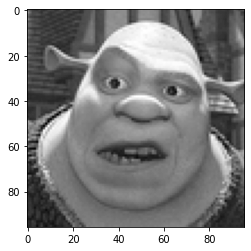

In [59]:
test_image = read_image(test_img_paths[-1])
plt.imshow(test_image[3, :, :], cmap='gray', vmin=-1, vmax=1)

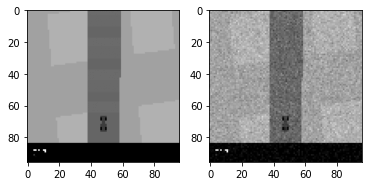

In [65]:
state = env.reset()
if skip_zoom is not None:
    for _ in range(skip_zoom):
        state = env.step([0, 0, 0])[0]

fix, ax = plt.subplots(1, 2)
ax[0].imshow(state[-1, :, :], cmap='gray', vmin=-1, vmax=1)
noisy_state = add_noise(state, noise_range[-1])
ax[1].imshow(noisy_state[-1, :, :], cmap='gray', vmin=-1, vmax=1)

# Models Evaluation

## Base

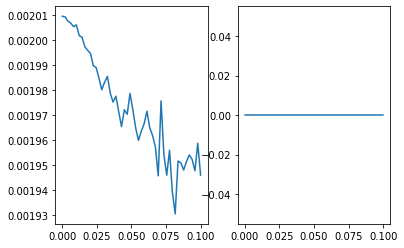

In [66]:
agent = load_agent('param/best_base.pkl', 'base', 10, 4, 0.99)
noises, epistemics, aleatorics = noise_sweep(agent, state, noise_range, noise_steps, noise_evals)

fig, ax = plt.subplots(1, 2)
ax[0].plot(noises, epistemics)
ax[1].plot(noises, aleatorics)

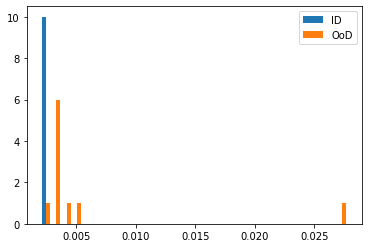

In [67]:
id_uncerts, ood_uncerts = ood_sweep(test_img_paths, skip_zoom, env, agent)
bins = 30
plt.figure()
plt.hist([id_uncerts, ood_uncerts], bins, label=['ID', 'OoD'])
plt.legend(loc='upper right')
plt.show()

## Dropout

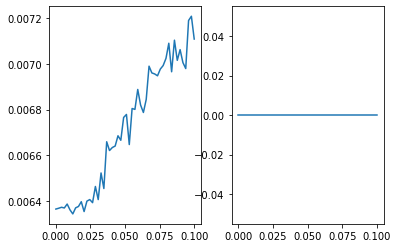

In [68]:
agent = load_agent('param/best_dropout.pkl', 'base', 25, 4, 0.99)
noises, epistemics, aleatorics = noise_sweep(agent, state, noise_range, noise_steps, noise_evals)

fig, ax = plt.subplots(1, 2)
ax[0].plot(noises, epistemics)
ax[1].plot(noises, aleatorics)

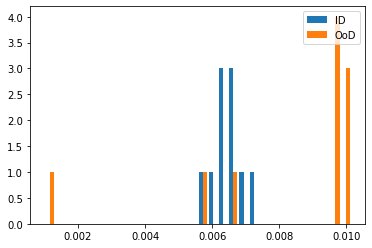

In [69]:
id_uncerts, ood_uncerts = ood_sweep(test_img_paths, skip_zoom, env, agent)
bins = 30
plt.figure()
plt.hist([id_uncerts, ood_uncerts], bins, label=['ID', 'OoD'])
plt.legend(loc='upper right')
plt.show()